## Measurement of the discord-type quantum correlations in the Werner State

In [1]:
import matplotlib.pyplot as plt
import qutip as qt
import numpy as np
import cmath

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [3]:
ro = [] # List where the density matrices will be saved

In [4]:
Id = qt.qeye(4) # Identity operator
Id

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

$ bell = |\phi> = \frac{1}{\sqrt{2}} \Big( |0>|0> + |1>|1> \Big) $

In [5]:
bell = qt.bell_state(state='00') # Bell state 00
bell_operator = bell*(bell.dag()) # Bell operator |\phi > < \phi|

In [6]:
BellOps = qt.Qobj(bell_operator.data.toarray(),dims=[[4],[4]]) # Convert Bell Operator to Proper Dimensions in Qutip
BellOps

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]

In [7]:
Plist = np.linspace(0,1,350) # List of elements P from 0 to 1 with 350 elements

An important class of quantum states are Werner states, which appear in realistic quantum computing devices and quantum communication environments when transmitting entangled states through noisy channels.
They are paradigmatic examples of quantum states and play an important role in quantum information theory.

The Werner states are a mixture of the states of bell $|\phi_{bell}>$ with noise of the form:

**Werner State**

$ \rho =  (1-p) |\phi > < \phi | + pI/4 $

In [8]:
def WernerState(p): # Compute the Werner state given a p-value
    werner = ( (1-p))*BellOps + (p/4)*Id
    return werner

where $|\phi_{bell}>= \frac{1}{\sqrt{2}}(|00> + |11>)$. The Werner state is characterized by a single real parameter $ p $ called fidelity.This quantity measures the separation of the Werner state from the Bell state.

In [9]:
for p in Plist: #Compute Werner state and save the density matrix in ro
    ro.append(WernerState(p))

In [10]:
sx = qt.sigmax() 
sy = qt.sigmay()
sz = qt.sigmaz()

$S_{i} = \sigma_{iA} \otimes I_{B} $

In [11]:
SX = qt.tensor(sx,qt.qeye(2))
SY = qt.tensor(sy,qt.qeye(2))
SZ = qt.tensor(sz,qt.qeye(2))

## Local Quantum Uncertainty  ##

\begin{equation}
LQU_{A}(\rho_{AB}) = 1 -  \lambda_{max}(W_{AB})
\end{equation}

\begin{equation}
    (W_{AB})_{ij}  =  Tr \Big[ \sqrt{\rho_{AB}} (\sigma_{iA} \otimes I_{B} )\sqrt{\rho_{AB}}  (\sigma_{jA} \otimes I_{B} ) \Big]
\end{equation}

In [12]:
def ComputeLQU(Plist,ro):
        LQU = []#List where the LQU of each density matrix is stored
        for ii in range(0,len(Plist)):
                evals11, ekets11 =ro[ii].eigenstates()#Obtain the eigenstates of the density matrix ro [p]
                SX_base_rho = (SX.transform(ekets11))#Make the change from the base of Sx to the base of the density matrix
                SY_base_rho = (SY.transform(ekets11))#Make the change from the base of Sy to the base of the density matrix
                SZ_base_rho = (SZ.transform(ekets11))#Make the change from the base of Sz to the base of the density matrix
                roDiagonal = (ro[ii].transform(ekets11))# Diagonalize the density matrix
                roDiagonalRaiz = qt.Qobj(np.sqrt(roDiagonal))# Obtain the root of the diagonalized density matrix 
                g = []# List where the elements of the matrix W will be stored
                SigmasBaseRho = [SX_base_rho, SY_base_rho, SZ_base_rho]# List of Sx, Sy, Sz operators
                for i in range(0,3):
                    for j in range(0,3):  
                        A = roDiagonalRaiz*(qt.Qobj(SigmasBaseRho[i].data.toarray(),dims=[[4],[4]])) 
                        B = roDiagonalRaiz*(qt.Qobj(SigmasBaseRho[j].data.toarray(),dims=[[4],[4]]))  
                        AB = A*B 
                        g.append( AB.tr() )  # Matrix element ij
                Matrix_W_A1 = qt.Qobj(np.matrix([[g[0]  , g[1]  , g[2] ] #Construct the matrix W
                                                ,[g[3]  , g[4]  , g[5] ]
                                                ,[g[6]  , g[7]  , g[8] ]]))
                evals1, ekets1 =Matrix_W_A1.eigenstates() #Obtain the eigenstates of the matrix W
                LQU.append(1-np.amax(evals1)) # Obtain LQU 
        return LQU 

## Quantum Fisher Information as a measurement of quantum correlations ##

\begin{equation}
F(\rho,H_{A})  = \frac{1}{2} \sum_{i \neq j} \frac{(\lambda_{i} - \lambda_{j})^2}{\lambda_{i}+\lambda_{j}} | <\psi_{i}| K |\psi_{j}>|^2,
\end{equation}

\begin{equation}
\mathcal{Q}(\rho_{AB}) = IP(\rho_{AB}) =  \underset{K^{A}}{min} F(\rho_{AB}, K_{A}),
\end{equation}

\begin{equation}
 \mathcal{Q}(\rho_{AB}) =  IP(\rho_{AB})=1 - \lambda_{max}(W),
\end{equation}

\begin{equation}
\begin{aligned}
    (W)_{mn}  = \sum_{i,j} \frac{2\lambda_{i} \lambda_{j}}{\lambda_{i}+\lambda_{j}} <\psi_{i}| \sigma_{m,A}  \otimes I_{B} |\psi_{j}> <\psi_{j}|  \sigma_{n,A}  \otimes I_{B} |\psi_{i}> 
    \end{aligned}
\end{equation}

In [13]:
def Compute_element(SigmasBaseRho,evals,label1,label2):
    g=[]# List where the elements are stored to calculate the matrix element W [label1.label2]
    for i in range(0,4):
        for j in range(0,4):
            if i==j:
                g.append(0)
            elif (evals[i]+evals[j]) < 0.0000000000000000001:
                g.append(0) # If the denominator of the formula to obtain the element W [label1.label2] is close to zero, the saved element will be zero  
            else: 
                g.append( ((2*(evals[i]*evals[j]))/(evals[i]+evals[j]))*(SigmasBaseRho[label1][i,j]*SigmasBaseRho[label2][j,i] )  )  # Compute the matrix element W [label1.label2]                                
    return g

In [14]:
def ComputeFisherMin(Plist,ro):
        FisherMin= [] #List where the quantum correlation of each density matrix is stored
        for ii in range(0,len(Plist)):
                evals11, ekets11 =ro[ii].eigenstates()#Obtain the eigenstates of the density matrix ro [p]
                SX_base_rho = (SX.transform(ekets11))#Make the change from the base of Sx to the base of the density matrix
                SY_base_rho = (SY.transform(ekets11))#Make the change from the base of Sy to the base of the density matrix
                SZ_base_rho = (SZ.transform(ekets11))#Make the change from the base of Sz to the base of the density matrix
                SigmasBaseRho = [SX_base_rho, SY_base_rho, SZ_base_rho]# List of Sx, Sy, Sz operators
                g11=[] # List where the values will be saved to obtain the matrix element W11
                g12=[] # "                                                             "  W12
                g13=[]
                g21=[]
                g22=[]
                g23=[]
                g31=[]
                g32=[]
                g33=[]
                g11 = Compute_element(SigmasBaseRho,evals11,0,0) # Compute the values to get the element W11
                g12 = Compute_element(SigmasBaseRho,evals11,0,1) # Compute the values to get the element W12
                g13 = Compute_element(SigmasBaseRho,evals11,0,2) # Compute the values to get the element W13
                g21 = Compute_element(SigmasBaseRho,evals11,1,0) # "                                   " W21
                g22 = Compute_element(SigmasBaseRho,evals11,1,1) # "                                   " W22
                g23 = Compute_element(SigmasBaseRho,evals11,1,2) # "                                   " W23
                g31 = Compute_element(SigmasBaseRho,evals11,2,0) # "                                   " W31
                g32 = Compute_element(SigmasBaseRho,evals11,2,1) # "                                   " W32
                g33 = Compute_element(SigmasBaseRho,evals11,2,2)# "                                    " W33
                W11 = np.sum(g11) # The sum is done to obtain the matrix element W11          
                W12 = np.sum(g12) # "                                          " W12           
                W13 = np.sum(g13) # "                                          " W13  
                W21 = np.sum(g21) # "                                          " W21            
                W22 = np.sum(g22) # "                                          " W22           
                W23 = np.sum(g23) # "                                          " W23           
                W31 = np.sum(g31) # "                                          " W31
                W32 = np.sum(g32) # "                                          " W32
                W33 = np.sum(g33) # "                                          " W33
                Matriz_W_A1 = qt.Qobj(np.matrix([[W11  , W12  , W13 ] # Construct the matrix W
                                                ,[W21  , W22  , W23 ]
                                                ,[W31  , W32  , W33 ]]))
                evals1, ekets1 =Matriz_W_A1.eigenstates() #Obtain the eigenstates of the matrix W
                FisherMin.append(1-np.amax(evals1))  # Obtain the measure of the quantum correlation based on the quantum fisher information
        return FisherMin

In [15]:
Fisher1 = [] # List where the measurement of quantum correlations based on the quantum fisher information is stored for each density matrix
LQU1 = [] # List where the LQU is stored for each density matrix

In [16]:
Fisher1 = ComputeFisherMin(Plist,ro)
Fi1 = np.array(Fisher1)

In [17]:
LQU1 = ComputeLQU(Plist,ro)
Sk1 = np.array(LQU1)

We compute the concurrence, a measure of entanglement, to the werner state. The concurrence is found through the density matrix $ \rho $,

\begin{equation}
C(\rho) = max \{0, \lambda_{1} - \lambda_{2} - \lambda_{3} - \lambda_{4}  \},
\label{equation:concurrencia}
\end{equation}

where $\lambda _{1} \geq  \lambda _{2} \geq  \lambda _{3} \geq  \lambda _{4}$ are the eigenvalues of the matrix

\begin{equation}
R = \sqrt{\rho^{1/2} \widetilde{\mathcal{\rho}}  \rho^{1/2} },
\label{equation:Matriz_R}
\end{equation}

with

\begin{equation}
\widetilde{\mathcal{\rho}} =  (\sigma_{y} \otimes \sigma_{y}) \rho (\sigma_{y} \otimes \sigma_{y}),
\label{equation:rho_tilde}
\end{equation}

A nonzero concurrence is an entanglement mark. For a separable state the concurrence is zero and for a maximally entangled state it is $ 1 $. We also compute $\mathcal{Q}(\rho)$ y $LQU(\rho)$ for Werner state with different $ p $.

In [18]:
Concu = []; # List where the concurrence is stored for each density matrix

In [19]:
for ii in range(0,len(Plist)):
    Concu.append(qt.concurrence(qt.Qobj(ro[ii].data.toarray(),dims=[[2, 2], [2, 2]])))#Compute the concurrence for each density matrix

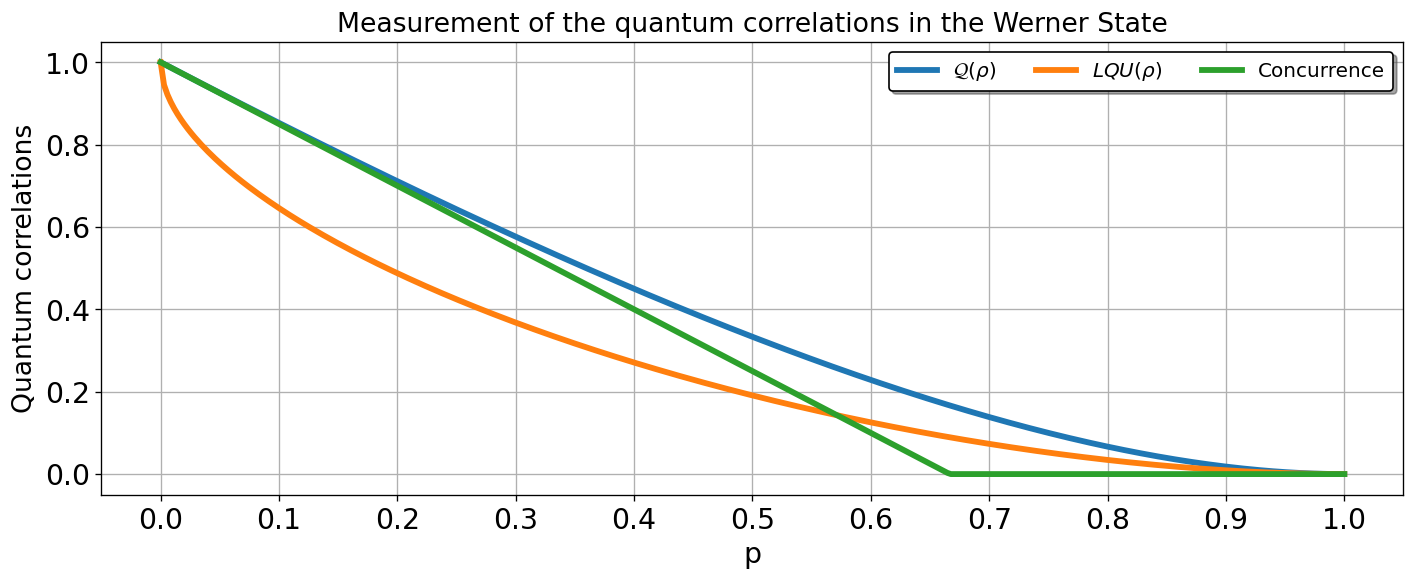

In [20]:
plt.figure(figsize = (14,5))
plt.title('Measurement of the quantum correlations in the Werner State', fontsize = 16 )
plt.plot(Plist,Fi1.real, label= r'$\mathcal{Q}(\rho)$', linewidth=3.5)
plt.plot(Plist,Sk1.real, label= r'$LQU(\rho)$'  ,linewidth=3.5)
plt.plot(Plist,Concu, label= 'Concurrence'  ,linewidth=3.5)

plt.grid()
plt.xlabel('p',fontsize = 17)
plt.ylabel('Quantum correlations',fontsize = 16)
plt.legend(ncol=3, shadow = True, fontsize = 'large', edgecolor ='black') 
plt.yticks(fontsize = 17)
plt.xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], fontsize = 17)


plt.savefig('quantum_correlations_werner.pdf', dpi=500)
plt.show()

The Werner state is separable when $p\geq \frac{2}{3} = 0.6666$. However we can notice that  $\mathcal{Q}(\rho) > 0 $ y $LQU(\rho) > 0$ in all the range of $p$ except in $p=0$. Furthermore, when entanglement is null, that is, the concurrence is equal to zero, there are still quantum correlations. 
$\mathcal{Q}(\rho)$, $LQU(\rho)$ and entanglement coincide for pure states, considering mixed states like the Werner state we can begin to see the differences. Although this is a simple case, similar behaviors occur in more complex systems.